In [1]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import getpass
import requests 
import json
import contextily as ctx
from pandas import ExcelWriter
import censusdata

user = getpass.getuser()
sys.dont_write_bytecode = True
sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

### Read census api key from file

In [2]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

### Read selected ACS varibles from csv

In [3]:
acs_coc_selected_vars = pd.read_csv('Data/ACS_Table_Variables_COC_Factors.csv')

In [4]:
acs_vars_lst = acs_coc_selected_vars['ACS_Table_Variable'].tolist()

### Query ACS API
#### [Census American Community Survey 5-Year Data API Documentation](https://www.census.gov/data/developers/data-sets/acs-5year.html)

In [5]:
api_file = 'census_api_key.txt'

api_key = get_file_contents(api_file)

In [6]:
var = ','.join(acs_vars_lst)
counties = '001,013,041,055,075,081,085,095,097'
state = '06'
url = 'https://api.census.gov/data/2018/acs/acs5?get={var}&for=tract:*&in=county:{counties}&in=state:{state}&key={api_key}'.format(var=var,
                                                                                                                                 counties=counties,
                                                                                                                                 state=state,
                                                                                                                                   api_key=api_key)
rq = requests.get(url)
data = rq.json()
acs_df = pd.DataFrame(data[1:],columns=data[0])

In [7]:
acs_df['county'].unique()

array(['055', '085', '095', '075', '013', '081', '001', '097', '041'],
      dtype=object)

### Change data type to integer select columns

In [8]:
acs_df[acs_vars_lst] = acs_df[acs_vars_lst].apply(pd.to_numeric)

In [9]:
acs_df['geoid'] = acs_df['state'] + acs_df['county'] + acs_df['tract']

### Rename columns for consistancy with prior CoCs

In [10]:
cols = {'county':'county_fips',
        'B03002_001E':'tot_pop_min',
        'B01001_001E':'tot_pop_sen',
        'C17002_001E':'tot_pop_pov_det',
       'C18108_001E':'tot_pop_civ_ni',
       'B08201_001E':'tot_hh',
       'B11004_001E':'tot_fam',
       'B16005_001E':'tot_pop_over5',
       'B25070_010E':'pop_hus_rent50',
       'B08201_002E':'pop_zvhhs'}
acs_df.rename(columns=cols, inplace=True)

### Calculate CoC and populations

In [11]:
acs_df['pop_minority'] = (acs_df['tot_pop_min'] - 
                          acs_df['B03002_003E'])
acs_df['pop_over75'] = (acs_df['B01001_023E'] + 
                        acs_df['B01001_024E'] + 
                        acs_df['B01001_025E'] + 
                        acs_df['B01001_047E'] + 
                        acs_df['B01001_048E'] + 
                        acs_df['B01001_049E'])
acs_df['pop_spfam'] = (acs_df['B11004_010E'] + 
                       acs_df['B11004_016E'])
acs_df['pop_lep'] = (acs_df['B16005_007E'] + 
                     acs_df['B16005_008E'] + 
                     acs_df['B16005_012E'] + 
                     acs_df['B16005_013E'] + 
                     acs_df['B16005_017E'] + 
                     acs_df['B16005_018E'] + 
                     acs_df['B16005_022E'] + 
                     acs_df['B16005_023E'] + 
                     acs_df['B16005_029E'] + 
                     acs_df['B16005_030E'] + 
                     acs_df['B16005_034E'] + 
                     acs_df['B16005_035E'] + 
                     acs_df['B16005_039E'] + 
                     acs_df['B16005_040E'] + 
                     acs_df['B16005_044E'] + 
                     acs_df['B16005_045E'])
acs_df['pop_below200'] = (acs_df['tot_pop_pov_det'] - 
                          acs_df['C17002_008E'])
acs_df['pop_disability'] = (acs_df['tot_pop_civ_ni'] - 
                            (acs_df['C18108_005E'] + 
                             acs_df['C18108_009E'] + 
                             acs_df['C18108_013E']))

### Calculate CoC shares

In [12]:
acs_df['pct_minority'] = (np.where(acs_df['tot_pop_min'] == 0,0,
                                   (acs_df['pop_minority']/
                                    acs_df['tot_pop_min'])))
acs_df['pct_over75'] = (np.where(acs_df['tot_pop_sen'] == 0,0,
                                 (acs_df['pop_over75']/
                                  acs_df['tot_pop_sen'])))
acs_df['pct_spfam'] = (np.where(acs_df['tot_fam'] == 0,0,
                                (acs_df['pop_spfam']/
                                 acs_df['tot_fam'])))
acs_df['pct_lep'] = (np.where(acs_df['tot_pop_over5'] == 0,0,
                              (acs_df['pop_lep']/
                               acs_df['tot_pop_over5'])))
acs_df['pct_below200'] = np.where(acs_df['tot_pop_pov_det'] == 0,0,
                                  (acs_df['pop_below200']/
                                   acs_df['tot_pop_pov_det']))
acs_df['pct_disab'] = np.where(acs_df['tot_pop_civ_ni'] == 0,0,
                               (acs_df['pop_disability']/
                                acs_df['tot_pop_civ_ni']))
acs_df['pct_zvhhs'] = np.where(acs_df['tot_hh'] == 0,0,
                               (acs_df['pop_zvhhs']/
                                acs_df['tot_hh']))
acs_df['pct_hus_rent50'] = np.where(acs_df['tot_hh'] == 0,0,
                                    (acs_df['pop_hus_rent50']/
                                     acs_df['tot_hh']))

In [13]:
acs_df.head(5)

,tot_pop_min,B03002_003E,tot_pop_sen,B01001_023E,B01001_024E,B01001_025E,B01001_047E,B01001_048E,B01001_049E,tot_pop_pov_det,...,pop_below200,pop_disability,pct_minority,pct_over75,pct_spfam,pct_lep,pct_below200,pct_disab,pct_zvhhs,pct_hus_rent50
0,2772,1388,2772,23,9,10,77,8,8,2580,...,873,392,0.499278,0.048701,0.297345,0.130384,0.338372,0.149675,0.135379,0.160650
1,4127,2874,4127,34,19,14,30,54,46,4125,...,591,382,0.303610,0.047734,0.054027,0.087235,0.143273,0.092561,0.005806,0.020645
2,722,396,722,23,0,0,0,0,0,119,...,103,80,0.451524,0.031856,0.363636,0.008310,0.865546,0.672269,0.891892,0.594595
3,6918,1563,6918,35,17,19,126,26,71,6845,...,460,263,0.774068,0.042498,0.033134,0.043160,0.067202,0.038155,0.021295,0.045198
4,4863,1951,4863,83,27,20,89,67,69,4863,...,776,515,0.598807,0.073000,0.084932,0.087213,0.159572,0.105902,0.099839,0.067096


### Flag cocs and coc levels (high, higher, highest) 

In [14]:
def flag_condition_calc(row, df_share_column, standard_deviation):
    cond = (df_share_column.mean() + 
            (standard_deviation * 
             df_share_column.std())).round(decimals=2)
    if row > cond:
        return 1
    else:
        return 0

In [15]:
def flag_mult_columns(dataframe, dictionary, standard_deviation):
    for key, value in dictionary.items():
        dataframe[value] = (dataframe[key]
                            .apply(
                                lambda row : flag_condition_calc(row,acs_df[key],
                                                                 standard_deviation)))

### Flag halfsd columns and count factors

In [16]:
cols_dict_halfsd = {'pct_over75':'over75_halfsd',
                    'pct_minority':'minority_halfsd',
                   'pct_spfam':'spfam_halfsd',
                   'pct_disab':'disab_halfsd',
                   'pct_lep':'lep_halfsd',
                   'pct_below200':'below200_halfsd',
                   'pct_zvhhs':'zvhh_halfsd',
                   'pct_hus_rent50':'hus_rent50_halfsd'}


In [17]:
flag_mult_columns(acs_df,cols_dict_halfsd,.5)

In [18]:
halfsd_cols_list = ['below200_halfsd',
             'minority_halfsd',
             'spfam_halfsd',
             'disab_halfsd',
             'lep_halfsd',
             'over75_halfsd',
             'zvhh_halfsd',
             'hus_rent50_halfsd']
acs_df['count_disadfact_halfsd'] = acs_df[halfsd_cols_list].sum(axis=1)

In [19]:
acs_df[halfsd_cols_list][acs_df['count_disadfact_halfsd'] >= 1]

,below200_halfsd,minority_halfsd,spfam_halfsd,disab_halfsd,lep_halfsd,over75_halfsd,zvhh_halfsd,hus_rent50_halfsd
0,1,0,1,1,1,0,0,1
2,1,0,1,1,0,0,1,1
3,0,1,0,0,0,0,0,0
9,1,1,1,0,1,0,0,0
10,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
1582,0,0,0,1,0,0,0,0
1583,0,0,0,0,0,1,0,0
1585,0,0,0,0,0,1,0,0
1586,0,0,1,1,1,1,0,0


### Flag halfsd coc

In [20]:
halfsd_remain = ['spfam_halfsd',
                 'disab_halfsd',
                 'lep_halfsd',
                 'over75_halfsd',
                 'zvhh_halfsd',
                 'hus_rent50_halfsd']
halfsd_cond = (((acs_df['minority_halfsd'] == 1) & 
                (acs_df['below200_halfsd'] == 1)) | 
               ((acs_df['below200_halfsd'] == 1) & 
                (acs_df[halfsd_remain].sum(axis=1) >= 3))
              )
acs_df['coc_pba2050_halfsd'] = np.where(halfsd_cond,1,0)

In [21]:
acs_df[halfsd_cols_list][acs_df['coc_pba2050_halfsd'] == 1]

,below200_halfsd,minority_halfsd,spfam_halfsd,disab_halfsd,lep_halfsd,over75_halfsd,zvhh_halfsd,hus_rent50_halfsd
0,1,0,1,1,1,0,0,1
2,1,0,1,1,0,0,1,1
9,1,1,1,0,1,0,0,0
11,1,1,1,0,1,0,0,0
18,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1542,1,1,1,0,0,0,0,1
1544,1,1,1,0,1,0,0,1
1549,1,1,1,1,1,0,0,1
1564,1,0,1,1,1,0,0,0


### Flag onesd columns

In [22]:
cols_dict_onesd = {'pct_over75':'over75_onesd',
                    'pct_minority':'minority_onesd',
                   'pct_spfam':'spfam_onesd',
                   'pct_disab':'disab_onesd',
                   'pct_lep':'lep_onesd',
                   'pct_below200':'below200_onesd',
                   'pct_zvhhs':'zvhh_onesd',
                   'pct_hus_rent50':'hus_rent50_onesd'}

In [23]:
flag_mult_columns(acs_df,cols_dict_onesd,1)

In [24]:
onesd_cols_list = ['below200_onesd',
             'minority_onesd',
             'spfam_onesd',
             'disab_onesd',
             'lep_onesd',
             'over75_onesd',
             'zvhh_onesd',
             'hus_rent50_onesd']
acs_df['count_disadfact_onesd'] = acs_df[onesd_cols_list].sum(axis=1)

### Flag onesd coc

In [25]:
onesd_remain = ['spfam_onesd',
                 'disab_onesd',
                 'lep_onesd',
                 'over75_onesd',
                 'zvhh_onesd',
                 'hus_rent50_onesd']
onesd_cond = (((acs_df['minority_onesd'] == 1) & 
                (acs_df['below200_onesd'] == 1)) | 
               ((acs_df['below200_onesd'] == 1) & 
                (acs_df[onesd_remain].sum(axis=1) >= 3))
              )
acs_df['coc_pba2050_onesd'] = np.where(onesd_cond,1,0)

In [26]:
acs_df[onesd_cols_list][(acs_df['coc_pba2050_onesd'] == 1)]

,below200_onesd,minority_onesd,spfam_onesd,disab_onesd,lep_onesd,over75_onesd,zvhh_onesd,hus_rent50_onesd
2,1,0,1,1,0,0,1,1
19,1,1,1,1,0,0,1,1
34,1,1,1,0,1,0,0,0
35,1,1,1,0,1,0,0,1
38,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1481,1,1,1,0,1,0,0,1
1506,1,1,1,0,1,0,0,1
1507,1,0,1,0,1,0,0,1
1527,1,0,1,1,1,0,0,1


### Flag onehalfsd columns

In [27]:
cols_dict_onehalfsd = {'pct_over75':'over75_onehalfsd',
                    'pct_minority':'minority_onehalfsd',
                   'pct_spfam':'spfam_onehalfsd',
                   'pct_disab':'disab_onehalfsd',
                   'pct_lep':'lep_onehalfsd',
                   'pct_below200':'below200_onehalfsd',
                   'pct_zvhhs':'zvhh_onehalfsd',
                   'pct_hus_rent50':'hus_rent50_onehalfsd'}

In [28]:
flag_mult_columns(acs_df,cols_dict_onehalfsd,1.5)

In [29]:
onehalfsd_cols_list = ['below200_onehalfsd',
             'minority_onehalfsd',
             'spfam_onehalfsd',
             'disab_onehalfsd',
             'lep_onehalfsd',
             'over75_onehalfsd',
             'zvhh_onehalfsd',
             'hus_rent50_onehalfsd']
acs_df['count_disadfact_onehalfsd'] = acs_df[onehalfsd_cols_list].sum(axis=1)

In [30]:
acs_df[onehalfsd_cols_list][acs_df['count_disadfact_onehalfsd'] >= 1]

,below200_onehalfsd,minority_onehalfsd,spfam_onehalfsd,disab_onehalfsd,lep_onehalfsd,over75_onehalfsd,zvhh_onehalfsd,hus_rent50_onehalfsd
0,0,0,1,0,0,0,0,0
2,1,0,1,1,0,0,1,1
9,0,0,0,0,1,0,0,0
10,0,0,0,0,1,0,0,0
11,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
1553,0,0,0,0,1,0,0,0
1564,0,0,0,0,1,0,0,0
1570,0,0,0,1,0,0,0,0
1575,0,0,0,0,1,0,0,0


### Flag onehalfsd coc

In [31]:
onehalfsd_remain = ['spfam_onehalfsd',
                 'disab_onehalfsd',
                 'lep_onehalfsd',
                 'over75_onehalfsd',
                 'zvhh_onehalfsd',
                 'hus_rent50_onehalfsd']
onehalfsd_cond = (((acs_df['minority_onehalfsd'] == 1) & 
                (acs_df['below200_onehalfsd'] == 1)) | 
               ((acs_df['below200_onehalfsd'] == 1) & 
                (acs_df[onehalfsd_remain].sum(axis=1) >= 3))
              )
acs_df['coc_pba2050_onehalfsd'] = np.where(onehalfsd_cond,1,0)

In [32]:
acs_df[onehalfsd_cols_list][(acs_df['coc_pba2050_onehalfsd'] == 1)]

,below200_onehalfsd,minority_onehalfsd,spfam_onehalfsd,disab_onehalfsd,lep_onehalfsd,over75_onehalfsd,zvhh_onehalfsd,hus_rent50_onehalfsd
2,1,0,1,1,0,0,1,1
19,1,0,1,1,0,0,0,1
35,1,0,1,0,1,0,0,1
51,1,0,1,1,0,0,0,1
101,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
1401,1,0,0,1,1,1,1,0
1460,1,1,0,0,1,1,1,1
1466,1,1,1,1,1,1,1,0
1506,1,1,1,0,1,0,0,1


### Flag 2050 cocs

In [33]:
acs_df['coc_flag_pba2050'] = np.where((acs_df['coc_pba2050_halfsd'] == 1) | 
                                      (acs_df['coc_pba2050_onesd'] == 1) | 
                                      (acs_df['coc_pba2050_onehalfsd']),1,0)

In [34]:
acs_df[['coc_flag_pba2050',
        'coc_pba2050_halfsd',
        'coc_pba2050_onesd',
        'coc_pba2050_onehalfsd']][acs_df['coc_flag_pba2050'] == 1]

,coc_flag_pba2050,coc_pba2050_halfsd,coc_pba2050_onesd,coc_pba2050_onehalfsd
0,1,1,0,0
2,1,1,1,1
9,1,1,0,0
11,1,1,0,0
18,1,1,0,0
...,...,...,...,...
1542,1,1,0,0
1544,1,1,0,0
1549,1,1,1,0
1564,1,1,0,0


### Create coc classes

In [35]:
def set_coc_class(df):
    if df['coc_pba2050_onehalfsd'] == 1:
        return 'Highest'
    elif df['coc_pba2050_onesd'] == 1:
        return 'Higher'
    elif df['coc_pba2050_halfsd'] == 1:
        return 'High'
    else: 
        return 'NA'

In [36]:
acs_df['coc_class'] = acs_df.apply(set_coc_class,axis=1)

In [37]:
acs_df[acs_df['coc_class'] != 'NA']

,tot_pop_min,B03002_003E,tot_pop_sen,B01001_023E,B01001_024E,B01001_025E,B01001_047E,B01001_048E,B01001_049E,tot_pop_pov_det,...,spfam_onehalfsd,disab_onehalfsd,lep_onehalfsd,below200_onehalfsd,zvhh_onehalfsd,hus_rent50_onehalfsd,count_disadfact_onehalfsd,coc_pba2050_onehalfsd,coc_flag_pba2050,coc_class
0,2772,1388,2772,23,9,10,77,8,8,2580,...,1,0,0,0,0,0,1,0,1,High
2,722,396,722,23,0,0,0,0,0,119,...,1,1,0,1,1,1,5,1,1,Highest
9,8414,524,8414,77,0,72,158,17,17,8368,...,0,0,1,0,0,0,1,0,1,High
11,4855,68,4855,27,19,40,41,23,21,4790,...,0,0,1,0,0,0,2,0,1,High
18,5571,1096,5571,29,30,9,75,0,22,5501,...,0,0,0,0,0,0,0,0,1,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,5794,1335,5794,5,0,0,0,7,9,1743,...,0,0,0,1,0,1,2,0,1,High
1544,7820,2155,7820,62,51,24,42,89,105,7674,...,0,0,0,0,0,0,0,0,1,High
1549,4278,157,4278,64,29,25,79,40,63,4258,...,0,0,1,0,0,0,2,0,1,Higher
1564,5481,2238,5481,98,22,19,5,62,93,5436,...,0,0,1,0,0,0,1,0,1,High


### Merge with PBA2040 CoC table

In [38]:
coc_pba2040 = pd.read_csv('Data/COCs_ACS2014_tbl.csv')
coc_pba2040.head(10)

,OID,GEOID,TOT_POP,POP_MINORITY,POP_OVER75,POP_SPFAM,POP_LEP,POP_BELOW200,POP_DISABILITY,POP_HUS_RENT50,...,DISAB_25,LEP_20,LOWINC_30,ZVHH_10,RENT50OCCHUS_15,SUM_6,COCFLAG_2017,COCFLAG_2013,TOT_FAM,COUNTY_FIP
0,-1,6001400100,3385,1287,289,19,80,173,223,62,...,0,0,0,0,0,0,0,0,818,1.0
1,-1,6001400200,1939,549,131,15,0,161,143,16,...,0,0,0,0,0,0,0,0,479,1.0
2,-1,6001400300,5428,2092,347,65,131,781,408,181,...,0,0,0,1,0,1,0,0,1130,1.0
3,-1,6001400400,4279,1722,182,143,43,672,551,126,...,0,0,0,0,0,0,0,0,884,1.0
4,-1,6001400500,3516,1674,113,45,64,924,339,207,...,0,0,0,1,0,1,0,0,519,1.0
5,-1,6001400600,1750,1123,85,84,65,590,215,111,...,0,0,1,1,1,3,1,1,382,1.0
6,-1,6001400700,4396,2894,284,228,93,2129,792,440,...,0,0,1,1,1,3,1,1,915,1.0
7,-1,6001400800,3218,2052,129,82,34,870,384,231,...,0,0,0,1,0,1,0,0,630,1.0
8,-1,6001400900,2031,1052,26,160,21,528,228,154,...,0,0,0,0,1,2,0,0,445,1.0
9,-1,6001401000,5505,3946,306,342,213,2502,839,785,...,0,0,1,1,1,3,1,1,1069,1.0


In [39]:
coc_pba2040['geoid_txt'] = '0' + coc_pba2040['GEOID'].astype(str)

In [40]:
coc_pba2050_pba2040_compare = pd.merge(acs_df,coc_pba2040[['geoid_txt','COCFLAG_2017']],
                                       left_on='geoid',
                                       right_on='geoid_txt',
                                      how='left')

In [41]:
coc_pba2050_pba2040_compare.rename(columns={'COCFLAG_2017':'coc_flag_pba2040'},inplace=True)

### Sum pba2050 and pba2040 cocs for comparison

In [42]:
coc_pba2050_pba2040_compare[['coc_flag_pba2040','coc_flag_pba2050']].sum()

coc_flag_pba2040    365.0
coc_flag_pba2050    324.0
dtype: float64

### Sum pba2040 cocs and ACS2016 cocs for a sanity check
#### - Appears that CoCs are decreasing in the region from the ACS2014 figures to the ACS2018 figures

In [43]:
coc_dif_acs2014_acs2016 = pd.read_csv('Data/COC_Diff_ACS2014_ACS2016.csv')
coc_dif_acs2014_acs2016.head(5)

,Unnamed: 0,GEOID,COCFLAG_2017,COC_FLAG_2018,Gain_Loss_2014_2016
0,1,6001400100,0,0.0,0.0
1,2,6001400200,0,0.0,0.0
2,3,6001400300,0,0.0,0.0
3,4,6001400400,0,0.0,0.0
4,5,6001400500,0,0.0,0.0


In [44]:
coc_dif_acs2014_acs2016[['COCFLAG_2017','COC_FLAG_2018']].sum()

COCFLAG_2017     365.0
COC_FLAG_2018    336.0
dtype: float64

### Calculate coc gains and losses by tract for pba2040 and pba2050

In [45]:
coc_pba2050_pba2040_compare['coc_flag_pba2040'].fillna(0,inplace=True)
coc_pba2050_pba2040_compare['coc_flag_pba2040'] = coc_pba2050_pba2040_compare['coc_flag_pba2040'].astype(int)

In [46]:
coc_pba2050_pba2040_compare['gain_loss_pba2040_pba2050'] = (coc_pba2050_pba2040_compare['coc_flag_pba2050'] - 
                                                        coc_pba2050_pba2040_compare['coc_flag_pba2040'])

In [47]:
print('Between ACS2014 and ACS2018, COC tracts decreased by: ' 
      + coc_pba2050_pba2040_compare['gain_loss_pba2040_pba2050'].sum().astype(str))

Between ACS2014 and ACS2018, COC tracts decreased by: -41


### Select subset of columns to export to csv

In [48]:
coc_select_cols = ['geoid',
 'state',
 'county_fips',
 'tract',
 'tot_pop_min',
 'tot_pop_pov_det',
 'tot_pop_civ_ni',
 'tot_hh',
 'pop_zvhhs',
 'tot_fam',
 'tot_pop_over5',
 'pop_hus_rent50',
 'pop_minority',
 'pop_over75',
 'pop_spfam',
 'pop_lep',
 'pop_below200',
 'pop_disability',
 'pct_minority',
 'pct_over75',
 'pct_spfam',
 'pct_lep',
 'pct_below200',
 'pct_disab',
 'pct_zvhhs',
 'pct_hus_rent50',
 'over75_halfsd',
 'minority_halfsd',
 'spfam_halfsd',
 'disab_halfsd',
 'lep_halfsd',
 'below200_halfsd',
 'zvhh_halfsd',
 'hus_rent50_halfsd',
 'coc_flag_pba2040',
 'coc_flag_pba2050',
 'gain_loss_pba2040_pba2050', 
 'coc_class']

In [49]:
cocs_pba2050 = coc_pba2050_pba2040_compare[coc_select_cols].copy()

In [50]:
cocs_pba2050.rename(columns={'tot_pop_min':'tot_pop'},inplace=True)

In [51]:
cocs_pba2050

,geoid,state,county_fips,tract,tot_pop,tot_pop_pov_det,tot_pop_civ_ni,tot_hh,pop_zvhhs,tot_fam,...,spfam_halfsd,disab_halfsd,lep_halfsd,below200_halfsd,zvhh_halfsd,hus_rent50_halfsd,coc_flag_pba2040,coc_flag_pba2050,gain_loss_pba2040_pba2050,coc_class
0,06055200202,06,055,200202,2772,2580,2619,1108,150,565,...,1,1,1,1,0,1,1,1,0,High
1,06055200400,06,055,200400,4127,4125,4127,1550,9,981,...,0,0,0,0,0,0,0,0,0,NA
2,06055200900,06,055,200900,722,119,119,37,33,11,...,1,1,0,1,1,1,1,1,0,Highest
3,06085508101,06,085,508101,6918,6845,6893,2301,49,1841,...,0,0,0,0,0,0,0,0,0,NA
4,06085509202,06,085,509202,4863,4863,4863,1863,186,1095,...,0,0,0,0,0,0,0,0,0,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,06055201401,06,055,201401,3203,3192,3203,1193,55,960,...,0,0,0,0,0,0,0,0,0,NA
1584,06055201402,06,055,201402,3055,3032,3050,1206,9,975,...,0,0,0,0,0,0,0,0,0,NA
1585,06055201403,06,055,201403,682,656,682,279,15,204,...,0,0,0,0,0,0,0,0,0,NA
1586,06055201601,06,055,201601,2684,2684,2684,1065,42,665,...,1,1,1,0,0,0,1,0,-1,NA


In [52]:
cocs_pba2050.to_csv('Data/COCs_ACS2018_tbl.csv',index=False)

### Calculate regional statistics 

In [53]:
coc_region_stats = acs_df.agg({'pct_over75': ['mean','std'],
           'pct_minority': ['mean','std'],
           'pct_lep': ['mean','std'],
           'pct_spfam': ['mean','std'],
           'pct_below200': ['mean','std'],
           'pct_disab': ['mean','std'],
           'pct_zvhhs': ['mean','std'],
           'pct_hus_rent50': ['mean','std']}).transpose().reset_index()

In [54]:
coc_region_stats.rename(columns={'index':'factors'},inplace=True)

In [55]:
coc_region_stats

,factors,mean,std
0,pct_over75,0.064338,0.045397
1,pct_minority,0.583119,0.237270
2,pct_lep,0.078371,0.075754
3,pct_spfam,0.126049,0.091361
4,pct_below200,0.214262,0.142700
5,pct_disab,0.099265,0.045019
6,pct_zvhhs,0.090633,0.124128
7,pct_hus_rent50,0.099591,0.078651


In [56]:
coc_factors = {'pct_over75': 'Seniors 75 Years and Over',
           'pct_minority': 'Minorities',
           'pct_lep': 'Limited English Proficiency',
           'pct_spfam': 'Single Parent Families',
           'pct_below200': 'Low-Income (<200% Federal Poverty Level-FPL)',
           'pct_disab': 'People with Disability',
           'pct_zvhhs': 'Zero-Vehicle Household',
           'pct_hus_rent50': 'Rent-Burdened'}
coc_region_stats['factors'].replace(coc_factors,inplace=True)

In [57]:
coc_region_stats

,factors,mean,std
0,Seniors 75 Years and Over,0.064338,0.045397
1,Minorities,0.583119,0.237270
2,Limited English Proficiency,0.078371,0.075754
3,Single Parent Families,0.126049,0.091361
4,Low-Income (<200% Federal Poverty Level-FPL),0.214262,0.142700
5,People with Disability,0.099265,0.045019
6,Zero-Vehicle Household,0.090633,0.124128
7,Rent-Burdened,0.099591,0.078651


### Create fields for .5, 1, and 1.5 sd from mean

In [58]:
coc_region_stats['plus_half_sd'] = (coc_region_stats['mean'] + 
                                    (.5 * coc_region_stats['std']))
coc_region_stats['plus_one_sd'] = (coc_region_stats['mean'] + 
                                   coc_region_stats['std'])
coc_region_stats['plus_one_half_sd'] = (coc_region_stats['mean'] + 
                                       (1.5 * coc_region_stats['std']))

In [59]:
coc_region_stats

,factors,mean,std,plus_half_sd,plus_one_sd,plus_one_half_sd
0,Seniors 75 Years and Over,0.064338,0.045397,0.087037,0.109735,0.132433
1,Minorities,0.583119,0.237270,0.701754,0.820389,0.939024
2,Limited English Proficiency,0.078371,0.075754,0.116248,0.154125,0.192002
3,Single Parent Families,0.126049,0.091361,0.171730,0.217410,0.263091
4,Low-Income (<200% Federal Poverty Level-FPL),0.214262,0.142700,0.285612,0.356962,0.428312
5,People with Disability,0.099265,0.045019,0.121775,0.144285,0.166794
6,Zero-Vehicle Household,0.090633,0.124128,0.152697,0.214761,0.276825
7,Rent-Burdened,0.099591,0.078651,0.138916,0.178242,0.217567


In [60]:
coc_region_stats.to_csv('Data/COC_Regional_Stats_ACS2018.csv',index=False)

### Query Census TIGER Tracts to get Bay Area Census Tract geography

#### [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)

In [61]:
state = "'06'"
counties = "('001','013','041','055','075','081','085','095','097')"
url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/3/query?where=STATE={state}+AND+COUNTY+IN{counties}&outFields=GEOID&f=geojson'.format(state=state,counties=counties)

In [62]:
print(url)

https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/3/query?where=STATE='06'+AND+COUNTY+IN('001','013','041','055','075','081','085','095','097')&outFields=GEOID&f=geojson


In [63]:
geo_rq = requests.get(url)
tracts_json = geo_rq.json()
tracts_json

{'type': 'FeatureCollection',
 'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-122.24691999958634, 37.8854380001509],
      [-122.24683300044599, 37.884106000242014],
      [-122.2464390002607, 37.88120299980722],
      [-122.24515600032079, 37.869737000004946],
      [-122.24487699976319, 37.86627600002313],
      [-122.24533799989567, 37.86598600029502],
      [-122.24552500039171, 37.86403599982632],
      [-122.2440650000015, 37.860776000164364],
      [-122.24450500021753, 37.85912900004025],
      [-122.24234699986837, 37.85760999994971],
      [-122.24171500003169, 37.85724799988977],
      [-122.24115400034013, 37.857261999929044],
      [-122.23476100038182, 37.8577899999761],
      [-122.23418499972333, 37.85254299988343],
      [-122.2340840003393, 37.85251799978163],
      [-122.23129099978043, 37.85083900004186],
      [-122.2267480001997, 37.84996199998922],
      [-1

In [64]:
tracts_2018_gdf = gp.GeoDataFrame.from_features(tracts_json['features'],crs=tracts_json['crs']['properties']['name'])

In [65]:
print(tracts_2018_gdf.crs)

EPSG:4326


In [66]:
tracts_2018_gdf.head(5)

,geometry,GEOID
0,"POLYGON ((-122.24692 37.88544, -122.24683 37.8...",06001400100
1,"POLYGON ((-122.25742 37.84310, -122.25792 37.8...",06001400200
2,"POLYGON ((-122.26416 37.84000, -122.26563 37.8...",06001400300
3,"POLYGON ((-122.26181 37.84179, -122.26186 37.8...",06001400400
4,"POLYGON ((-122.26941 37.84811, -122.26923 37.8...",06001400500


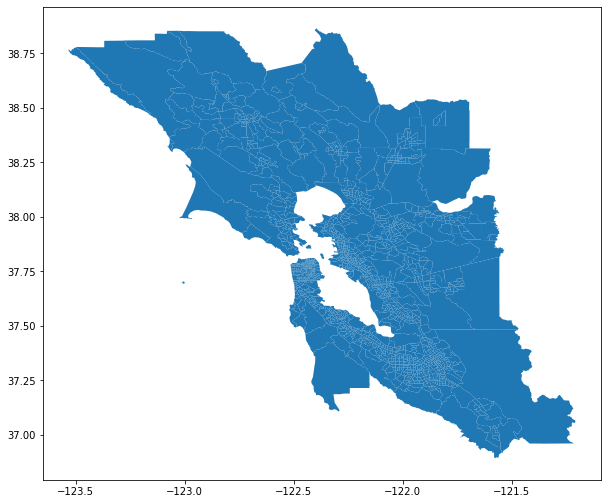

In [89]:
tracts_2018_gdf.plot(figsize=(10,10))

### Join census tracts to coc df

In [92]:
coc_tracts_pba2050 = pd.merge(tracts_2018_gdf,cocs_pba2050, left_on='GEOID',right_on='geoid',how='inner')

In [99]:
coc_tracts_pba2050

,geometry,GEOID,geoid,state,county_fips,tract,tot_pop,tot_pop_pov_det,tot_pop_civ_ni,tot_hh,...,spfam_halfsd,disab_halfsd,lep_halfsd,below200_halfsd,zvhh_halfsd,hus_rent50_halfsd,coc_flag_pba2040,coc_flag_pba2050,gain_loss_pba2040_pba2050,coc_class
0,"POLYGON ((-122.24692 37.88544, -122.24683 37.8...",06001400100,06001400100,06,001,400100,3115,3105,3115,1297,...,0,0,0,0,0,0,0,0,0,NA
1,"POLYGON ((-122.25742 37.84310, -122.25792 37.8...",06001400200,06001400200,06,001,400200,2025,2018,2025,855,...,0,0,0,0,0,0,0,0,0,NA
2,"POLYGON ((-122.26416 37.84000, -122.26563 37.8...",06001400300,06001400300,06,001,400300,5000,4962,5000,2441,...,0,0,0,0,1,0,0,0,0,NA
3,"POLYGON ((-122.26181 37.84179, -122.26186 37.8...",06001400400,06001400400,06,001,400400,3843,3830,3838,1750,...,1,0,0,0,0,0,0,0,0,NA
4,"POLYGON ((-122.26941 37.84811, -122.26923 37.8...",06001400500,06001400500,06,001,400500,3786,3768,3786,1622,...,0,0,0,0,0,1,0,0,0,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,"POLYGON ((-123.08100 38.85244, -123.08108 38.8...",06097154201,06097154201,06,097,154201,3874,3863,3874,1325,...,0,1,1,1,0,0,0,0,0,NA
1578,"POLYGON ((-123.27187 38.79917, -123.27263 38.7...",06097154202,06097154202,06,097,154202,5846,5769,5786,2207,...,0,1,0,0,0,0,0,0,0,NA
1579,"POLYGON ((-123.06783 38.36714, -123.07051 38.3...",06097154302,06097154302,06,097,154302,3369,3340,3351,1733,...,0,1,0,0,0,0,0,0,0,NA
1580,"POLYGON ((-123.53354 38.76841, -123.53111 38.7...",06097154303,06097154303,06,097,154303,1567,1567,1567,780,...,0,1,0,0,0,0,0,0,0,NA


In [95]:
coc_tracts_pba2050['coc_flag_pba2050'].sum()

324

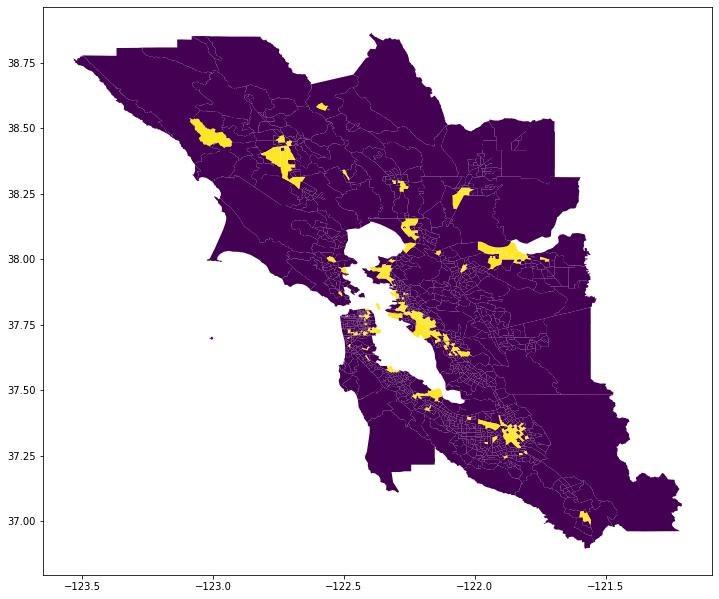

In [98]:
coc_tracts_pba2050.plot(figsize=(12,12),column='coc_flag_pba2050')

In [100]:
coc_tracts_pba2050.drop('GEOID', axis=1, inplace=True)

In [ ]:
coc_tracts_pba2050.to_file("output.json", driver="GeoJSON")